In [89]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from feature_engine.encoding import (
    OneHotEncoder,
    CountFrequencyEncoder,
    RareLabelEncoder,
    OrdinalEncoder,
)
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
)

import sweetviz as sv

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [2]:
base_path = Path('data')
output_path = Path('output')
FN_DATA = base_path / 'train.csv'
FN_TEST = base_path / 'test.csv'

In [3]:
df = pd.read_csv(FN_DATA)
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
df_test = pd.read_csv(FN_TEST)
df_test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


- Age has missing data for both train and test samples
- Fare is missing in the test sample

                                             |          | [  0%]   00:00 -> (? left)


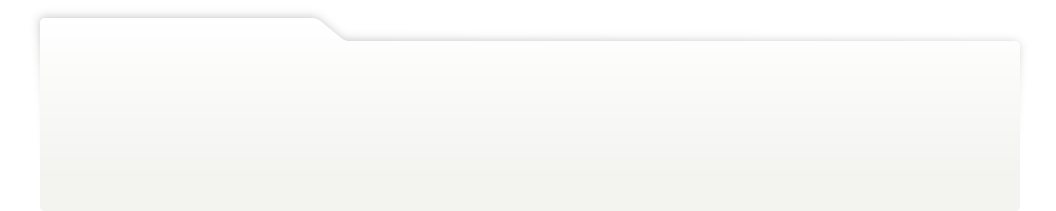
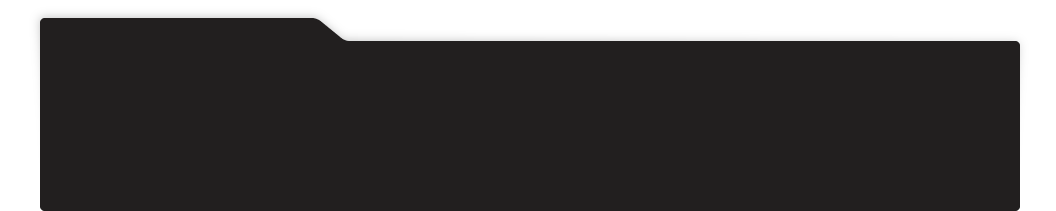
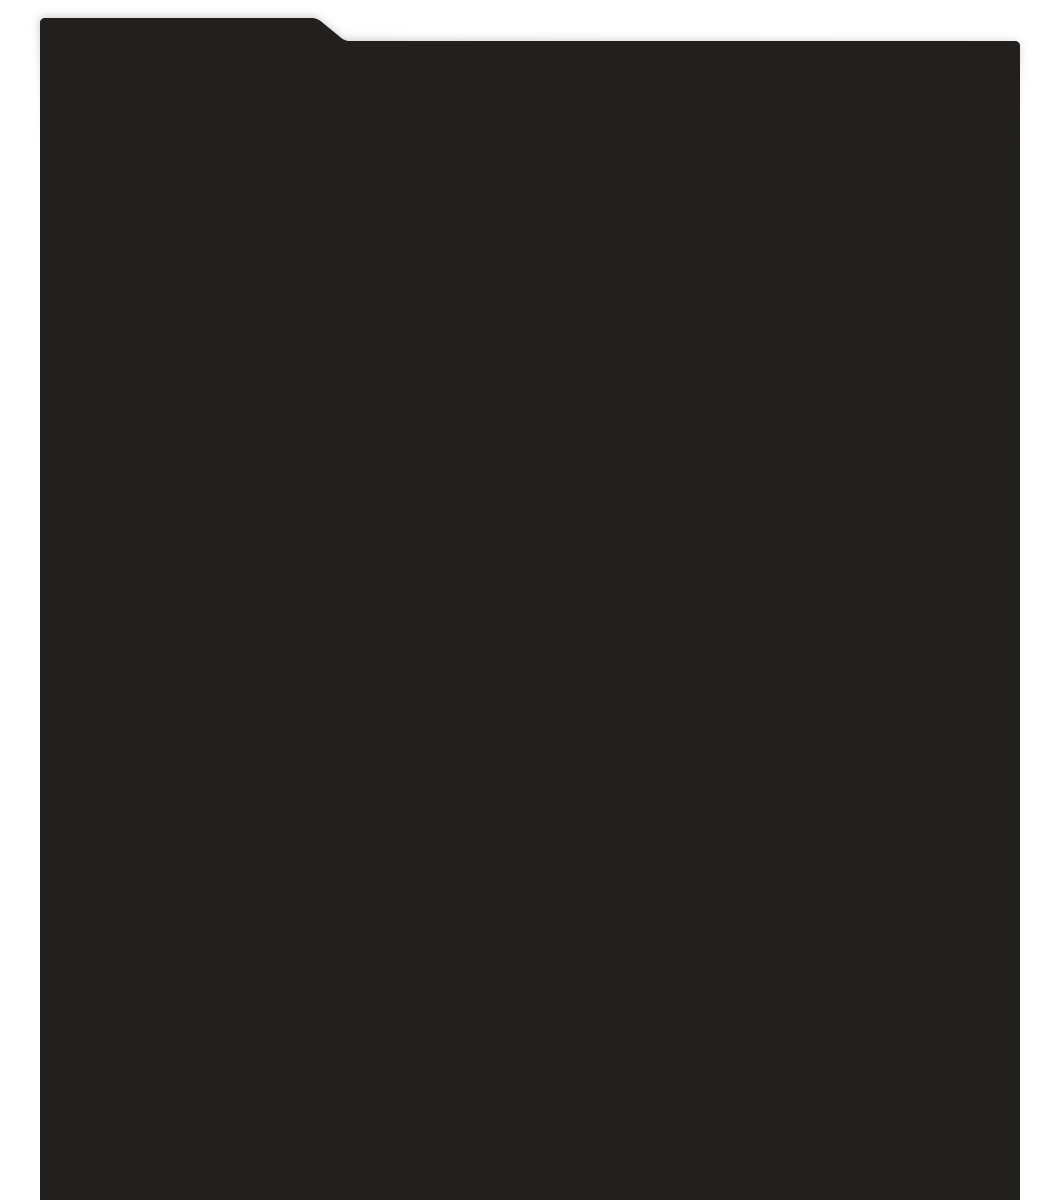
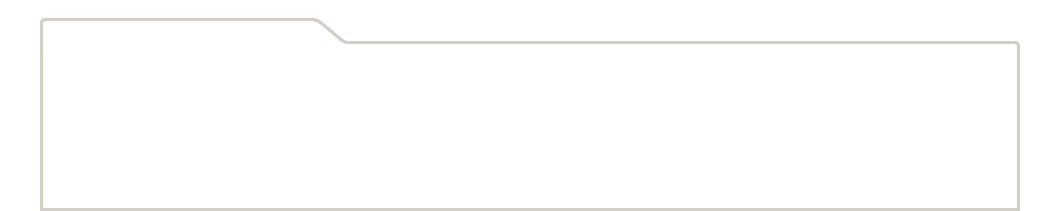
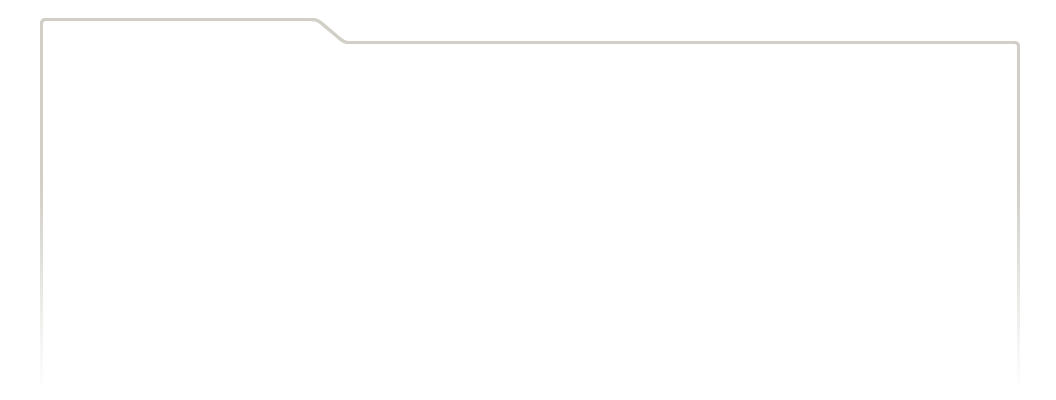
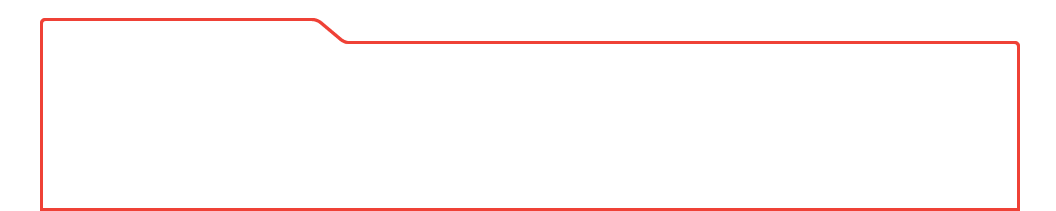
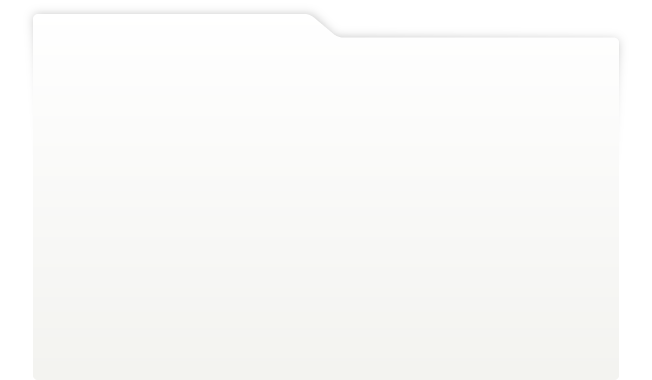
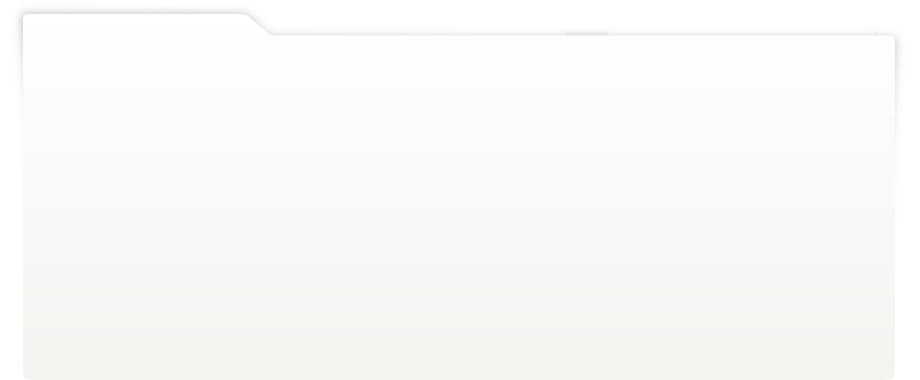
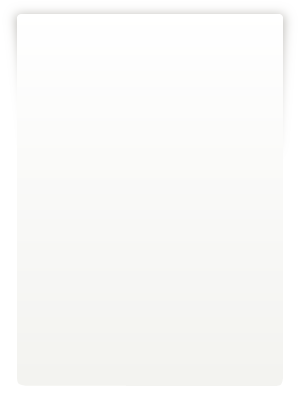
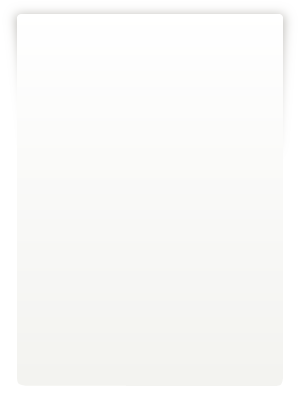
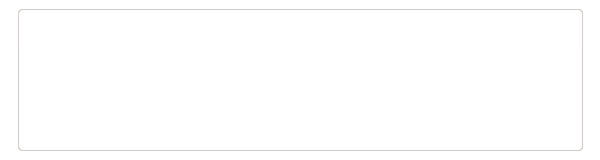
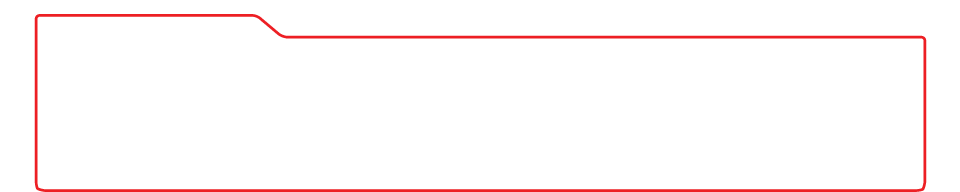
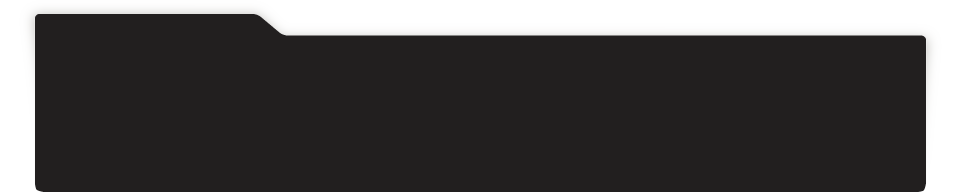
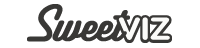
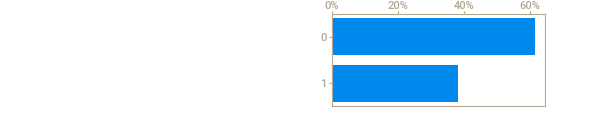
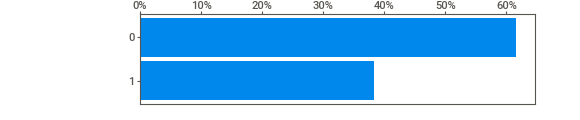
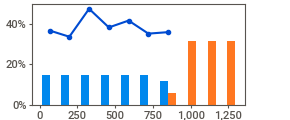
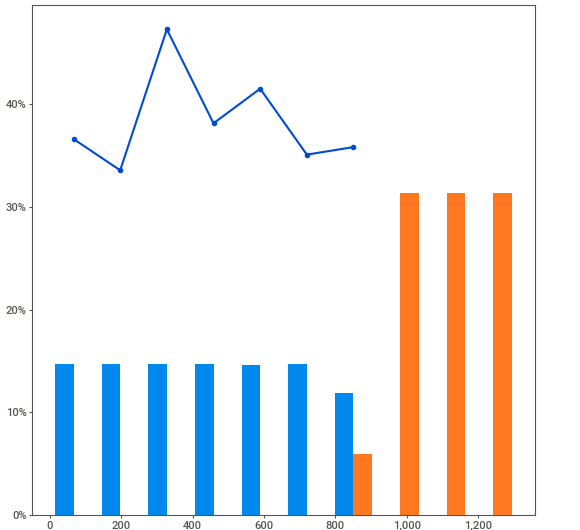
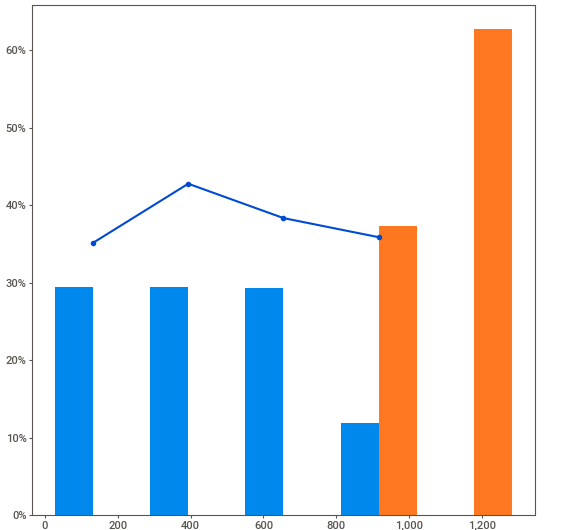
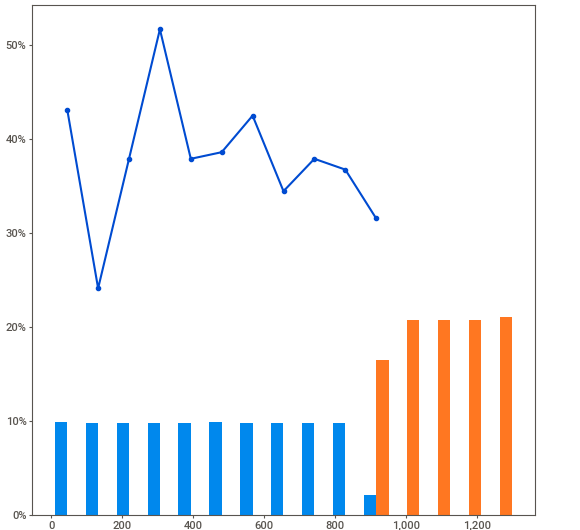
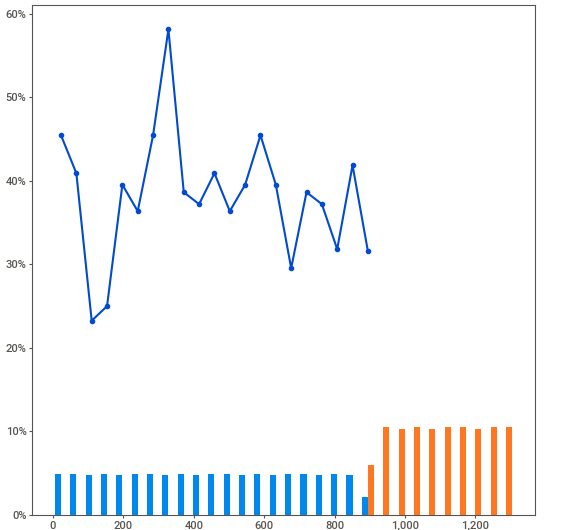
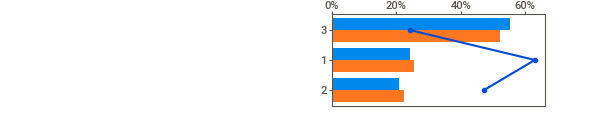
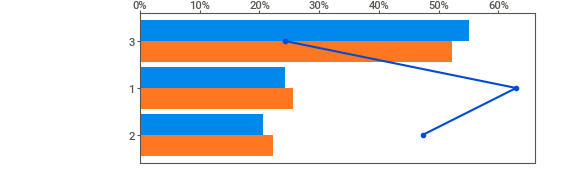
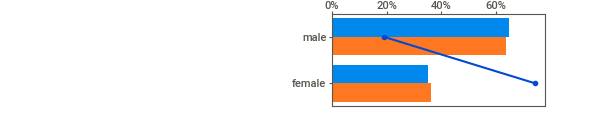
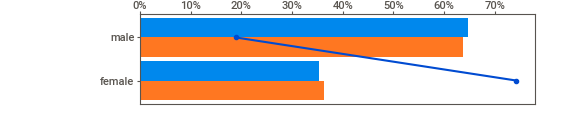
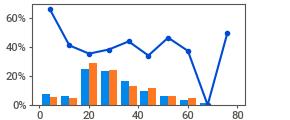
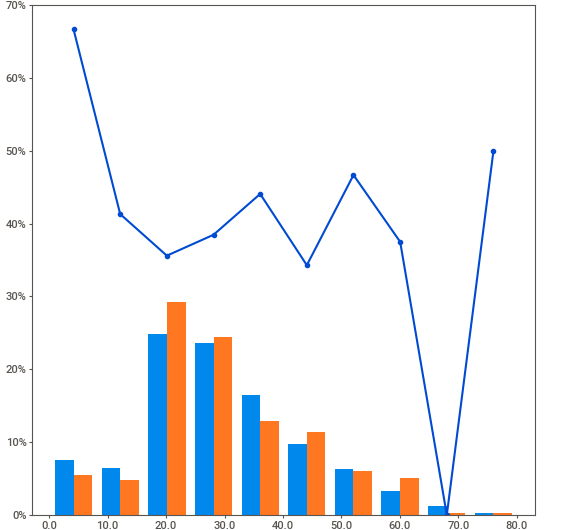
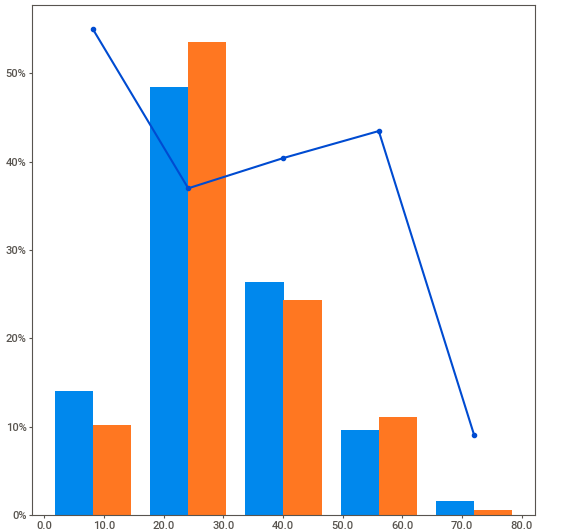
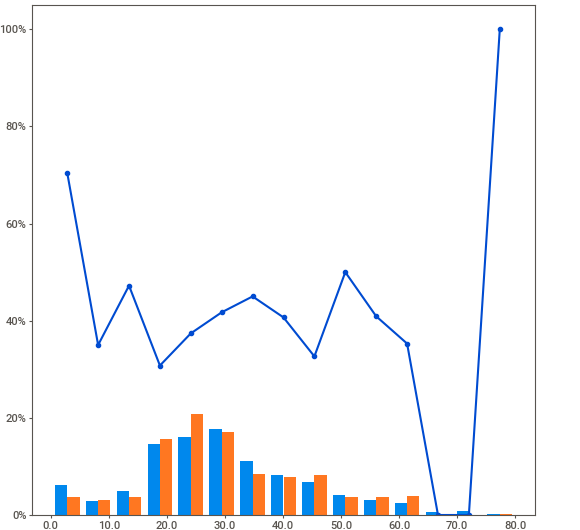
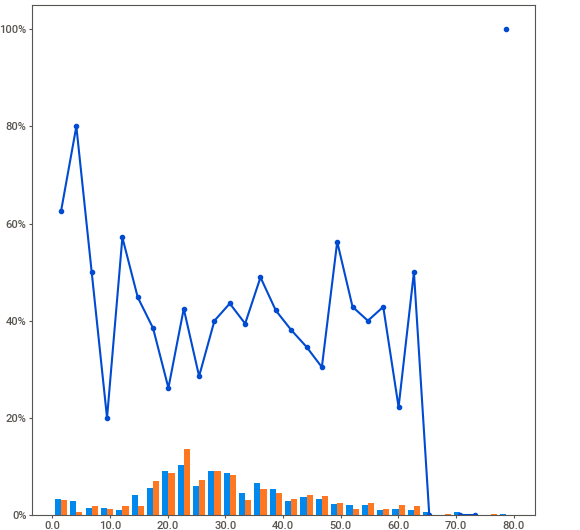
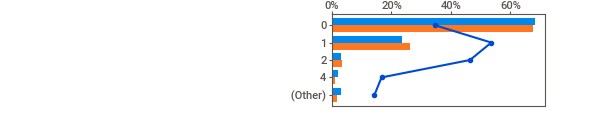
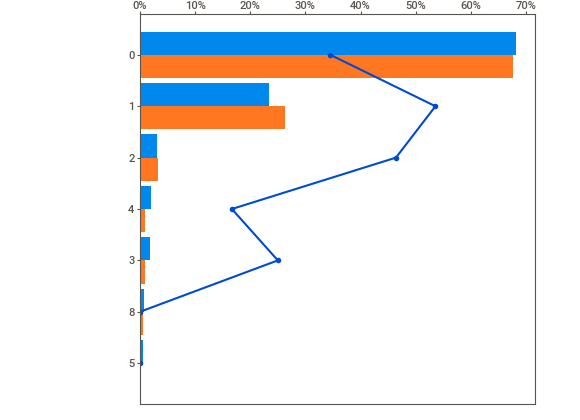
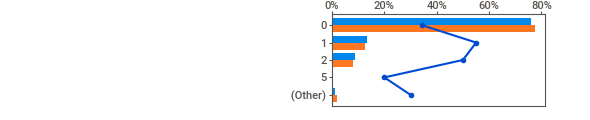
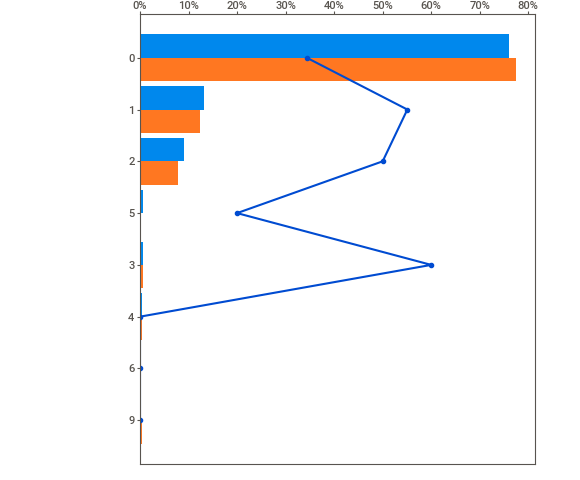
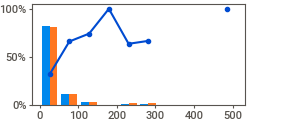
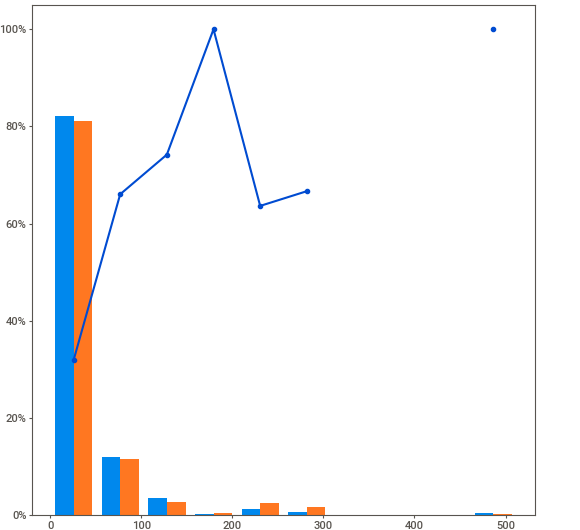
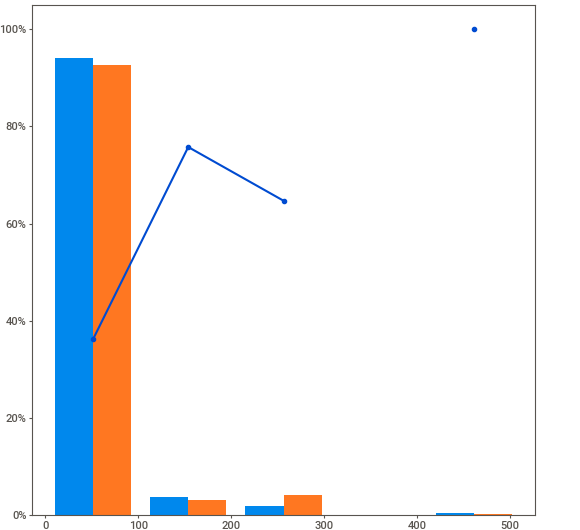
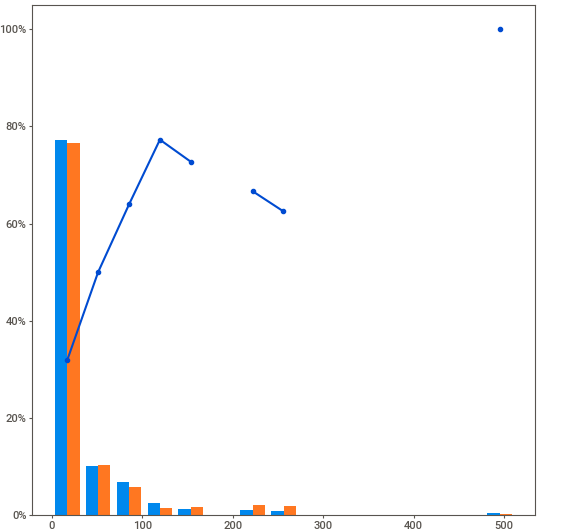
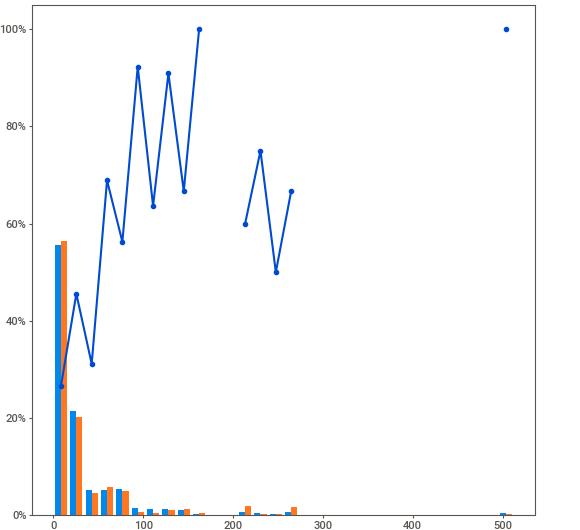
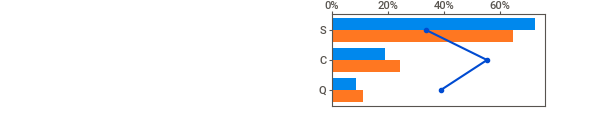
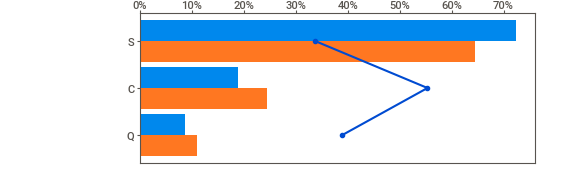
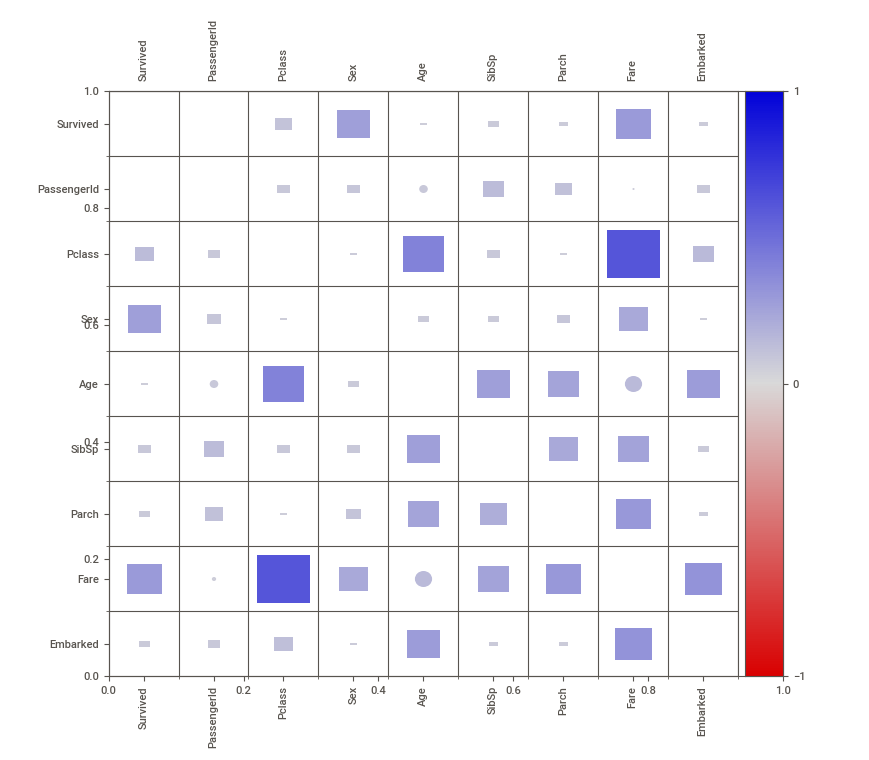
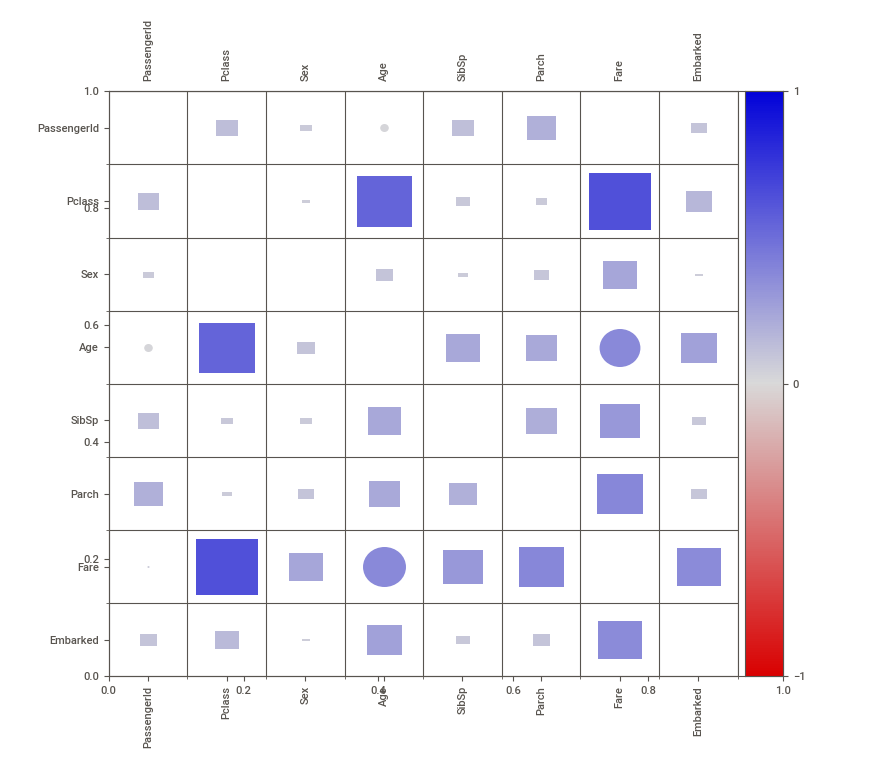

In [5]:
sv_tt_report = sv.compare([df, "Train"], [df_test, "Test"], "Survived")
sv_tt_report.show_notebook()

NOTES:
- Survived has is slightly imbalanced - no significant imbalance - no missing values
- PassengerId does not seem to have any significant value - little prediction value - no missing values
- Pclass
    - No missing values, no missing test values
    - Definite differences in survivability of classes
    - Only has 3 classes with slight imbalance
    - No decomposition available
    - Correlation with embarked, fare, and target
- Name
    - No missing values, no missing test values
    - 100% distinct values
    - Decomposition of title, name and surname
    - FE: Count # of names, Title as categorical feature
    - No correlation information
- Sex
    - No missing values, no missing test values
    - Correlation with Fare and target
- Age
    - 20% missing train values, 21% missing test values - Require imputation
    - Right skewed distribution
    - Small tail
    - Seems to be some difference in survivability
    - FE: Bucket ages
    - Correlation with Pclass, Embarked, SipSp, and Parch
- SibSp
    - No missing values, no missing test values
    - Significant imbalance in the variable
    - Significant difference in survivability rate
    - FE: Split into <=2 and >2
    - Correlation with Parch and Age
- Parch
    - No missing values, no missing test values
    - Significant imbalance in the variable
    - Significant difference in survivability rate
    - FE: Split into <=2 and >2
    - Correlation with SibSp, Fare, and Age
- Ticket
    - No missing values, no missing test values
    - Many distinct values
    - FE: Split ticket values into words (start of ticket) and numbers, and those containing only numbers
- Fare
    - No missing values, 1% missing test values - Imputation required
    - Log shaped distribution
    - Some outlier values - not unreasonable, but still outlier
    - Correlation with Pclass, Embarked, Parch, SibSp, Sex, and target
    - FE: Bucket values
- Cabin
    - Many misssing values in train and test - Drop feature
- Embarked
    - 1% missing values, no missing test values
    - Slight imbalance in categories
    - Correlation with Fare, Age

# Data processing

## Correcting

In [6]:
# None

## Completing

In [116]:
def fill_age(df):
    df['Age'] = df['Age'].fillna(df['Age'].median())
    return df

def fill_fare(df):
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    return df

def fill_embarked(df):
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    return df

def fill_cabin(df):
    df['Cabin'] = df['Cabin'].fillna('U')
    return df

def drop_features(df, drop_feat):
    return df.drop(drop_feat, axis=1)


In [119]:
drop_feat = []

df_preprocessed = (
    df.pipe(fill_age)
    .pipe(fill_fare)
    .pipe(fill_embarked)
    .pipe(fill_cabin)
    .pipe(drop_features, drop_feat)
)
df_preprocessed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,U,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,U,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [120]:
df_preprocessed.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Creating

In [121]:
def add_family_size(df):
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    return df


def bucket_col(df:pd.DataFrame, col:str, buckets:list, labels:list=None, right:bool=True):
    if labels is None:
        labels = False
    df[f"basket_{col}"] = pd.cut(df[col], buckets, labels=labels, right=right)
    return df


def add_aggregated_pclass(df):
    age_grp = df.groupby(["Pclass"], as_index=False)["Age"].mean()
    age_grp = age_grp.rename(columns={"Age": "age_mean"})
    age_grp = age_grp.merge(
        df.groupby(["Pclass"], as_index=False)["Age"].median(), on="Pclass"
    )
    age_grp = age_grp.rename(columns={"Age": "age_median"})
    df = df.merge(age_grp, on="Pclass")
    return df

def decompose_cabin(df):
    df["Cabin"] = df["Cabin"].apply(lambda x: x[0])
    return df

def decompose_full_name(df):
    df['Name'] = df['Name'].astype(str)
    df["Title"] = df["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
    df["LastName"] = df["Name"].apply(lambda x: x.split(",")[0].strip())
    df["FirstName"] = df["Name"].apply(lambda x: x.split(",")[1].split(".")[1].strip())
    df["FirstName"] = df["FirstName"].apply(lambda x: x.split("(")[0].strip())
    df["FirstName"] = df["FirstName"].apply(lambda x: x.split('"')[0].strip())
    df["count_name"] = df["FirstName"].apply(lambda x: len(x.split(" ")))
    return df

def split_ticket(df):
    df["TicketPrefix"] = df["Ticket"].apply(lambda x: x.split(" ")[0])
    df["TicketNumber"] = df["Ticket"].apply(lambda x: x.split(" ")[-1])
    df["TicketPrefix"] = np.where(df["TicketPrefix"] == df["TicketNumber"], "None", df["TicketPrefix"])
    return df

In [122]:
age_bins = np.arange(0, 100, 10)
age_labels = np.arange(0, len(age_bins)-1, 1)
fare_bins = np.arange(0, 600, 50)
fare_labels = np.arange(0, len(fare_bins)-1, 1)

df_fe = (
    df_preprocessed.pipe(add_family_size)
    .pipe(bucket_col, "SibSp", [0,2, 100], [0, 1], right=False)
    .pipe(bucket_col, "Parch", [0,2, 100], [0, 1], right=False)
    .pipe(add_aggregated_pclass)
    .pipe(bucket_col, "Age", age_bins, age_labels)
    .pipe(decompose_full_name)
    .pipe(decompose_cabin)
    .pipe(bucket_col, "Fare", fare_bins, fare_labels, right=False)
    .pipe(split_ticket)
)
df_fe


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,basket_SibSp,basket_Parch,age_mean,age_median,basket_Age,Title,LastName,FirstName,count_name,basket_Fare,TicketPrefix,TicketNumber
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,1,0,0,25.932627,28.0,2,Mr,Braund,Owen Harris,2,0,A/5,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,0,0,36.812130,35.0,3,Mrs,Cumings,John Bradley,2,1,PC,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,0,0,0,25.932627,28.0,2,Miss,Heikkinen,Laina,1,0,STON/O2.,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,0,0,36.812130,35.0,3,Mrs,Futrelle,Jacques Heath,2,1,None,113803
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,0,0,0,25.932627,28.0,3,Mr,Allen,William Henry,2,0,None,373450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,U,S,0,0,0,29.765380,28.0,2,Rev,Montvila,Juozas,1,0,None,211536
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,0,0,0,36.812130,35.0,1,Miss,Graham,Margaret Edith,2,0,None,112053
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,U,S,3,0,1,25.932627,28.0,2,Miss,Johnston,Catherine Helen,2,0,W./C.,6607
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,0,0,0,36.812130,35.0,2,Mr,Behr,Karl Howell,2,0,None,111369


## Converting

In [178]:
def cast_category(df, cols):
    df[cols] = df[cols].astype("category")
    return df

def cast_col_list(val):
        return [val] if not isinstance(val, list) else val
    
def encoder(df, cols, encoder, save_encoder=False, overwrite=False):
    encoders = {
        'onehot': OneHotEncoder(),
        'countfreq': CountFrequencyEncoder(),
        'rare': RareLabelEncoder(),
        'ordinal': OrdinalEncoder(encoding_method='arbitrary')
    }

    if encoder not in encoders.keys():
        raise ValueError(f"Encoder {encoder} not found. Available encoders: {encoders.keys()}")
    
    for col in cols:
        if not Path.exists(Path(f"encoders/{col}_{encoder}.pkl")) and not overwrite:
            raise ValueError(f"Encoder {encoder} not found for column {col}. Run encoder function first.")

    cols = cast_col_list(cols)
    for col in cols:
        if Path.exists(Path(f"encoders/{col}_{encoder}.pkl")) and not overwrite:
            enc = joblib.load(f'encoders/{col}_{encoder}.pkl')
            print(enc)
            save_encoder = False
        else:
            enc = encoders[encoder]
        
        if overwrite:
            df_enc = enc.fit_transform(df[[col]])
        else:
            df_enc = enc.transform(df[[col]])

        if encoder == 'onehot':
            df = pd.concat([df, df_enc], axis=1)
            df = df.drop(columns=[col])
        else:
            df[col] = df_enc
        if save_encoder:
            joblib.dump(enc, f'encoders/{col}_{encoder}.pkl')
    return df

def drop_columns(df, cols):
    df = df.drop(columns=cols)
    return df

def scale_features(df, cols, scale, save_encoder=False, overwrite=False):
    if scale:
        for col in cols:
            if Path.exists(Path(f"encoders/{col}_minmax_scaler.pkl")) and not overwrite:
                encoder = joblib.load(f'encoders/{col}_minmax_scaler.pkl')
                save_encoder = False
            else:
                encoder = MinMaxScaler()
            df[col] = encoder.fit_transform(df[[col]])
            if save_encoder:
                joblib.dump(encoder, f'encoders/{col}_minmax_scaler.pkl')
        return df
    else:
        return df

In [179]:
drop_scope = ['Name', 'Ticket', 'FirstName', 'LastName', 'PassengerId', 'TicketNumber']
scale_cols = ['Age', 'Fare', 'FamilySize', 'age_mean', 'age_median', 'count_name', 'basket_Fare', 'basket_Age', 'SibSp', 'Parch', 'Title', "TicketPrefix"]
cat_cols = ['Pclass', 'Embarked']
label_cols = ['TicketPrefix', 'Title', 'Sex', 'Cabin']

save_encoder = True
overwrite = True
scale = False

df_processed = (
    df_fe.pipe(cast_category, [*cat_cols, *label_cols])
    .pipe(encoder, cat_cols, 'onehot', save_encoder=save_encoder, overwrite=overwrite)
    .pipe(encoder, label_cols, 'rare', save_encoder=save_encoder, overwrite=overwrite)
    .pipe(encoder, label_cols, 'ordinal', save_encoder=save_encoder, overwrite=overwrite)
    .pipe(drop_columns, drop_scope)
    .pipe(scale_features, scale_cols, scale, save_encoder=save_encoder, overwrite=overwrite)
)

c:\Users\gelle\anaconda3\envs\latest\Lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\gelle\anaconda3\envs\latest\Lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Cabin is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


In [170]:
df_processed

,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,FamilySize,basket_SibSp,basket_Parch,age_mean,age_median,basket_Age,Title,count_name,basket_Fare,TicketPrefix,Pclass_3,Pclass_1,Pclass_2,Embarked_S,Embarked_C,Embarked_Q
0,0,0.0,22.0,1,0,7.2500,0.0,1,0,0,25.932627,28.0,2,0.0,2,0,0.0,1,0,0,1,0,0
1,1,1.0,38.0,1,0,71.2833,1.0,1,0,0,36.812130,35.0,3,1.0,2,1,1.0,0,1,0,0,1,0
2,1,1.0,26.0,0,0,7.9250,0.0,0,0,0,25.932627,28.0,2,2.0,1,0,0.0,1,0,0,1,0,0
3,1,1.0,35.0,1,0,53.1000,1.0,1,0,0,36.812130,35.0,3,1.0,2,1,2.0,0,1,0,1,0,0
4,0,0.0,35.0,0,0,8.0500,0.0,0,0,0,25.932627,28.0,3,0.0,2,0,2.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.0,27.0,0,0,13.0000,0.0,0,0,0,29.765380,28.0,2,3.0,1,0,2.0,0,0,1,1,0,0
887,1,1.0,19.0,0,0,30.0000,6.0,0,0,0,36.812130,35.0,1,2.0,2,0,2.0,0,1,0,1,0,0
888,0,1.0,28.0,1,2,23.4500,0.0,3,0,1,25.932627,28.0,2,2.0,2,0,0.0,1,0,0,1,0,0
889,1,0.0,26.0,0,0,30.0000,1.0,0,0,0,36.812130,35.0,2,0.0,2,0,2.0,0,1,0,0,1,0


# Correlation

<Axes: >

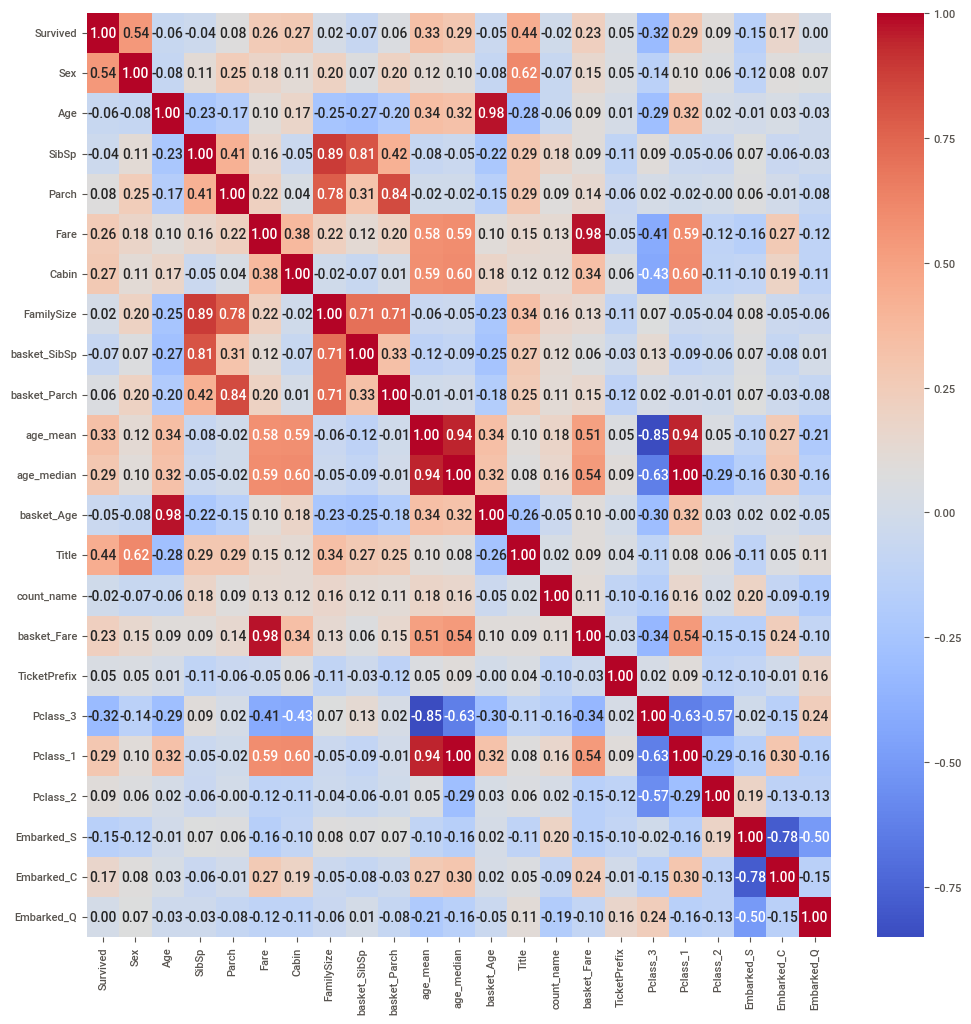

In [180]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df_processed.corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=ax)

- Fare (postively) and Pclass (negatively) are weakly correlated to Survived. 
- Pclass and Fare, as well as Age and Pclass are also negatively correlated
- Parch and SibSp are also correlated

Feature engineering ideation
- Average/Median `Age` per `Pclass`
- Min/max `Age` per `Pclass`
- Average/Median `Fare` per `Pclass`
- Sum of `Parch` and `SibSp`

In [157]:
df_processed.columns

Index(['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'FamilySize', 'basket_SibSp', 'basket_Parch', 'age_mean', 'age_median',
       'basket_Age', 'Title', 'count_name', 'basket_Fare', 'TicketPrefix',
       'Pclass_3', 'Pclass_1', 'Pclass_2', 'Embarked_S', 'Embarked_C',
       'Embarked_Q'],
      dtype='object')

In [158]:
df_processed.isna().sum()

Survived        0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Cabin           0
FamilySize      0
basket_SibSp    0
basket_Parch    0
age_mean        0
age_median      0
basket_Age      0
Title           0
count_name      0
basket_Fare     0
TicketPrefix    0
Pclass_3        0
Pclass_1        0
Pclass_2        0
Embarked_S      0
Embarked_C      0
Embarked_Q      0
dtype: int64

# Model

In [181]:
x_train, x_temp, y_train, y_temp = train_test_split(df_processed.drop("Survived", axis=1), df_processed['Survived'], test_size=0.3, stratify=df_processed['Survived'])
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1, min_samples_leaf=4, min_samples_split=3)

rs = RandomizedSearchCV(
    model,
    {
        "n_estimators": np.arange(10, 200, 10),
        "max_depth": np.arange(1, 50, 5),
        "min_samples_leaf": np.arange(1, 15, 1),
        "min_samples_split": np.arange(2, 15, 1),
        "ccp_alpha": [0.0, 0.01, 0.025, 0.05, 0.075, 0.1, 1.5, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 3, 4, 5, 6],
        "bootstrap": [True, False],
    },
    n_iter=100,
    cv=cv,
    scoring="roc_auc",
    random_state=1,
    n_jobs=-1,
    verbose=2,
)

rs.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(max_depth=5,
                                                    min_samples_leaf=4,
                                                    min_samples_split=3,
                                                    random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.0, 0.01, 0.025, 0.05,
                                                      0.075, 0.1, 1.5, 0.2, 0.3,
                                                      0.4, 0.5, 0.75, 1, 2, 3,
                                                      4, 5, 6],
                                        'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   random_state=1, scoring='roc_auc', verbose=2)

In [182]:
mod_params = rs.best_params_

model = RandomForestClassifier(**mod_params, random_state=1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_val_pred = model.predict(x_val)

accuracy = accuracy_score(y_test, y_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)

auc = roc_auc_score(y_test, y_pred)
auc_val = roc_auc_score(y_val, y_val_pred)

print(f"{accuracy}, {accuracy_val}")
print(f'{auc}, {auc_val}')

0.835820895522388, 0.8283582089552238
0.8032128514056225, 0.8069887429643527


In [183]:
# pd.DataFrame(model.coef_, columns=model.feature_names_in_).T.sort_values(by=0, ascending=False)
pd.DataFrame(model.feature_importances_, index=x_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

,importance
Title,0.204362
Sex,0.176742
Fare,0.132225
Age,0.093449
age_mean,0.046735
basket_Age,0.040048
Pclass_3,0.036029
Cabin,0.035567
FamilySize,0.034996
basket_Fare,0.029011


<Axes: >

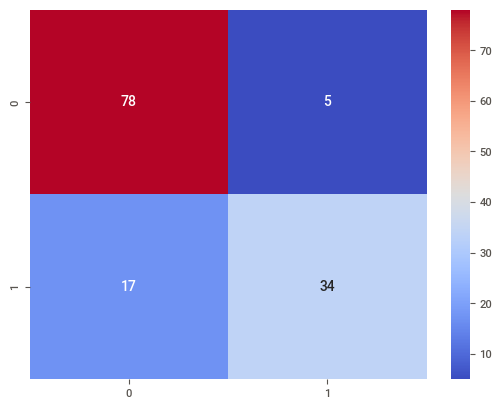

In [184]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')

# Test predictions

In [185]:
df_test = pd.read_csv(FN_TEST)
df_test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [186]:
drop_feat = []


age_bins = np.arange(0, 100, 10)
age_labels = np.arange(0, len(age_bins)-1, 1)
fare_bins = np.arange(0, 600, 50)
fare_labels = np.arange(0, len(fare_bins)-1, 1)

drop_scope = ['Name', 'Ticket', 'FirstName', 'LastName', 'TicketNumber']
scale_cols = ['Age', 'Fare', 'FamilySize', 'age_mean', 'age_median', 'count_name', 'basket_Fare', 'basket_Age', 'SibSp', 'Parch', 'Title', "TicketPrefix"]
cat_cols = ['Pclass', 'Embarked']
label_cols = ['TicketPrefix', 'Title', 'Sex', 'Cabin']

save_encoder = False
overwrite = False
scale = False


df_test_processed = (
    df_test.pipe(fill_age)
    .pipe(fill_fare)
    .pipe(fill_embarked)
    .pipe(fill_cabin)
    .pipe(drop_features, drop_feat)

    .pipe(add_family_size)
    .pipe(bucket_col, "SibSp", [0,2, 100], [0, 1], right=False)
    .pipe(bucket_col, "Parch", [0,2, 100], [0, 1], right=False)
    .pipe(add_aggregated_pclass)
    .pipe(bucket_col, "Age", age_bins, age_labels)
    .pipe(decompose_full_name)
    .pipe(decompose_cabin)
    .pipe(bucket_col, "Fare", fare_bins, fare_labels, right=False)
    .pipe(split_ticket)

    .pipe(cast_category, [*cat_cols, *label_cols])
    .pipe(encoder, cat_cols, 'onehot', save_encoder=save_encoder, overwrite=overwrite)
    .pipe(encoder, label_cols, 'rare', save_encoder=save_encoder, overwrite=overwrite)
    .pipe(encoder, label_cols, 'ordinal', save_encoder=save_encoder, overwrite=overwrite)
    .pipe(drop_columns, drop_scope)
    .pipe(scale_features, scale_cols, scale, save_encoder=save_encoder, overwrite=overwrite)
)
df_passenger_id = df_test_processed["PassengerId"]
df_test_processed.drop(columns=["PassengerId"], inplace=True)
df_test_processed

OneHotEncoder()
OneHotEncoder()
RareLabelEncoder()
RareLabelEncoder()
RareLabelEncoder()
RareLabelEncoder()
OrdinalEncoder(encoding_method='arbitrary')
OrdinalEncoder(encoding_method='arbitrary')
OrdinalEncoder(encoding_method='arbitrary')
OrdinalEncoder(encoding_method='arbitrary')


,Sex,Age,SibSp,Parch,Fare,Cabin,FamilySize,basket_SibSp,basket_Parch,age_mean,age_median,basket_Age,Title,count_name,basket_Fare,TicketPrefix,Pclass_3,Pclass_1,Pclass_2,Embarked_S,Embarked_C,Embarked_Q
0,0.0,34.5,0,0,7.8292,0.0,0,0,0,25.009541,27.0,3,0.0,1,0,2.0,1,0,0,0,0,1
1,1.0,47.0,1,0,7.0000,0.0,1,0,0,25.009541,27.0,4,1.0,1,0,2.0,1,0,0,1,0,0
2,0.0,62.0,0,0,9.6875,0.0,0,0,0,28.681935,27.0,6,0.0,2,0,2.0,0,0,1,0,0,1
3,0.0,27.0,0,0,8.6625,0.0,0,0,0,25.009541,27.0,2,0.0,1,0,2.0,1,0,0,1,0,0
4,1.0,22.0,1,1,12.2875,0.0,2,0,0,25.009541,27.0,2,1.0,1,0,2.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,27.0,0,0,8.0500,0.0,0,0,0,25.009541,27.0,2,0.0,1,0,0.0,1,0,0,1,0,0
414,1.0,39.0,0,0,108.9000,1.0,0,0,0,39.747664,39.0,3,3.0,1,2,1.0,0,1,0,0,1,0
415,0.0,38.5,0,0,7.2500,0.0,0,0,0,25.009541,27.0,3,0.0,2,0,0.0,1,0,0,1,0,0
416,0.0,27.0,0,0,8.0500,0.0,0,0,0,25.009541,27.0,2,0.0,1,0,2.0,1,0,0,1,0,0


In [187]:
df_test_processed.columns.difference(x_train.columns)

Index([], dtype='object')

In [188]:
model_cols = model.feature_names_in_

y_test = model.predict(df_test_processed[model_cols])
output = pd.DataFrame({'PassengerId': df_passenger_id, 'Survived': y_test})
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [189]:
output.to_csv(base_path / output_path / f'output_{datetime.now().strftime("%Y%m%d%H%M%S")}.csv', index=False)